# CM50270 Reinforcement Learning: Coursework 3 (Mountain Car)

Please remember: 
(1) Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.
(2) Save your work regularly. 

###  Code for Mountain Car 

We provide a `MountainCar` class that you can use. This implementation is based on the problem description given in [Example 8.2](http://www.incompleteideas.net/book/ebook/node89.html) of Sutton & Barto (1998) The following cells in this section will walk you through the basic usage of this class.

We import the mountaincar module and create a `MountainCar` object called `env`. The `reset()` method chooses a random starting `position` and starting `velocity` for the car, and sets the `game_over` variable to `False`. You can access these state variables independently using the same names.

In [1]:
import numpy as np
import mountaincar

np.random.seed(7)

env = mountaincar.MountainCar()
env.reset()
print("Starting position of the car", env.position)
print("Starting velocity of the car", env.velocity)
if not env.game_over:
    print("Game is not over yet.")

Starting position of the car -0.454704306550481
Starting velocity of the car 0.03128512489633177
Game is not over yet.


You can visualize the current position of the car using the `plot()` method.

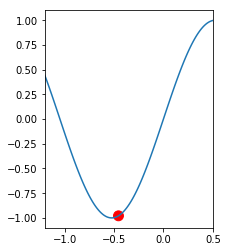

In [2]:
env.plot()

You can interact with the `MountainCar` environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. This method returns a `reward` signal, which is always -1.

The action can be one of the following integers:
* -1: full throttle reverse
*  0: zero throttle
*  1: full throttle forward

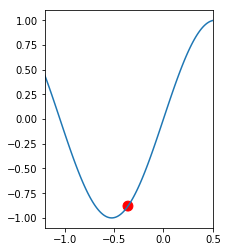

In [3]:
# Let's drive a bit full throttle forward and plot again.
env.make_step(action=1)
#print(env.position, env.velocity)
env.make_step(action=1)
#print(env.position, env.velocity)
env.make_step(action=1)
#print(env.position, env.velocity)
env.plot()

The following code snippet shows that even at full throttle the car cannot accelerate up the steep slope.

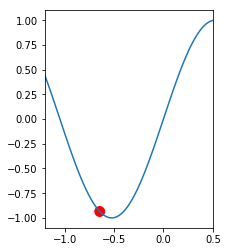

In [4]:
num_steps = 150
for episode in range(num_steps):
    # Always action 1 (full throttle forward)
    env.make_step(action=1)
    env.plot()

## Part 1 (50 marks):

For your reference, the pseudo-code for  _Linear, gradient-descent Sarsa($\lambda$)_ is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, [Section 8.4]:

Please plot an average learning curve for your agent. This should be a static figure of _precomputed_ results, clearly showing (1) how efficiently an average agent learns, and (2) how good the eventual policy is. In five sentences or less, describe your choice of parameter settings and your results.

In addition, please write code to produce a learning curve for a _single_ agent. This shoud be a dynamic figure that we can produce from scratch by executing your code. This figure can show less detail than the static plot. 

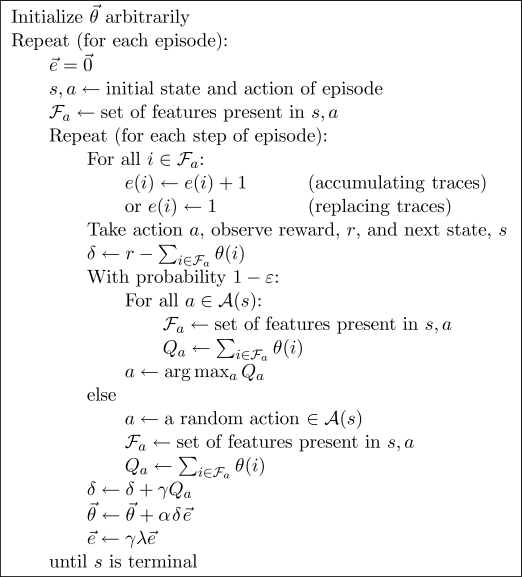

In [10]:
def plot_graph(line):

    x = np.arange(0, len(line))
    fig, (ax2) = plt.subplots(1,1)
    ax2.plot(x, line, color="Red", label="Steps")
    ax2.set_title("Steps to learn mountain car after 1000 episodes")
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Steps')
    plt.legend()
    plt.show()

In [96]:
import random
import matplotlib.pyplot as plt
%matplotlib inline


class Tiling:
    
    def __init__(self, env, number_of_features=10, grid_length=10):
        # Min and max values of velocity(y) and position(x).
        self.number_of_features = number_of_features
        self.grid_length = grid_length
        self.env = env
        self.min_x = self.env.position_min
        self.max_x = self.env.position_max
        self.min_y = self.env.velocity_min
        self.max_y = self.env.velocity_max
        
        # Number of tiles.
        self.num_tiles = number_of_features * grid_length * grid_length
        self.n = self.num_tiles * len(self.env.actions)
        
        # Tile width, height and offset values.
        self.tile_width = (self.max_x - self.min_x) / number_of_features
        self.tile_height = (self.max_y - self.min_y) / number_of_features
        self.max_offset_left = self.max_y + self.tile_height
        self.max_offset_right = self.max_x + self.tile_width
        
        # Default tile indices and tiling.
        self.tile_indices = []
        self.tiling = None
        
    
    def make_tiles(self):
        # Create default tiling.
        position_tile = np.linspace(self.min_x, self.max_x + self.tile_width, 10)
        velocity_tile = np.linspace(self.min_y, self.max_y + self.tile_height, 10)
        
        # Create empty list to store tiling.
        position_tiling = []
        velocity_tiling = []
        
        # Creates tiles.
        for i in range(self.number_of_features):
            
            # Make random offsets of tiles.
            position_offset = np.random.uniform(0, self.tile_width)
            velocity_offset = np.random.uniform(0, self.tile_height)

            # Minus offset from default tiling.
            post_tile = np.subtract(position_tile, position_offset)
            velo_tile = np.subtract(velocity_tile, velocity_offset)
            
            # Append each tile to a the position and velocity tiling lists
            position_tiling.append(post_tile)
            velocity_tiling.append(velo_tile)
        
        # Saves tilings to object.
        self.tiling = (position_tiling, velocity_tiling)
        
        
    def get_tile_indices(self, state, action):
        
        # Gets action index, to determine what set of indices to use depending on action.
        action_index = list(env.actions).index(action)
        
        # Position and velocity of mountain car.
        p = state[0]
        v = state[1]
        
        # Creates empty list to store indices.
        indices = []
        
        # Splits tiling into positon and velocity
        pos_tiling = self.tiling[0]
        vel_tiling = self.tiling[1]
        
        for i in range(self.number_of_features):
            # 'i' represents the first tiling to look at and find the indicies of where state lies in tiling,
            # And iterates through all tilings.
            pos_ind = np.digitize(p, pos_tiling[i])
            vel_ind = np.digitize(v, vel_tiling[i])
            index = (action_index * self.num_tiles) + i * (self.grid_length * self.grid_length) + (vel_ind * self.grid_length + pos_ind)
            indices.append(index)
        return indices


def get_Q(fa, theta):
    q_list = []
    for i in fa:
        q_list.append(theta[i])
    return sum(q_list)

def policy(t, state, fa, theta):
    action_list = []
    for action in env.actions:
        fa = t.get_tile_indices(state, action) 
        qa = get_Q(fa, theta)
        action_list.append(qa)
    max_q = max(action_list)
    if action_list.count(max_q) > 1:
        i = []
        for q in action_list:
            if q == max_q:
                i.append(action_list.index(q))
        i = random.choice(i)
    else:
        i = np.argmax(action_list)
    
    action = env.actions[i]
    q_prime = action_list[i]
    return action, q_prime
    

def play_sarsa(env, theta, lambada=0.9, alpha=0.01, epsilon=0.05, gamma=1, episodes=100, plot=False):
    
    t = Tiling(env, 10, 10) # Creates tiling object.
    t.make_tiles() # Creates tiling.
    print("it's working")
    
    # Checks to see if game is running with a used theta or a new one is neede to be initialised.
    if not list(theta):
        theta = np.zeros(t.n) 
        
    # List is used to accumulate steps in each episode.
    step_list = []
    
    for episode in range(episodes):
        step = 0 # Initialises steps at the beginning of each episode
        env.reset()
        e = np.zeros(t.n) # Initialises eligibility trace.
        delta = 0 # Sets default value of 0 to delta.
        
        # Current state of game and chooses random action to start game.
        state = (env.position, env.velocity)
        action = random.choice(env.actions)
        
        # Loop for each step of the game.
        while not env.game_over:
            fa = t.get_tile_indices(state, action)
            for i in fa:
                e[i] += 1 # Accumulating traces.
                #e[i] = 1 # Replacing traces.
            reward = env.make_step(action)
            state_prime = (env.position, env.velocity)
            delta = reward - get_Q(fa, theta)
            
            # Greedy policy 'Ɛ'.
            if np.random.uniform(0, 1) > epsilon: 
                action_prime, Q_prime = policy(t, state_prime, fa, theta)
            else:
                action_prime = random.choice(env.actions)
                fa = t.get_tile_indices(state_prime, action_prime)
                Q_prime = get_Q(fa, theta)
                
            # Performs updates. 
            delta = delta + gamma * Q_prime
            theta = theta + (e * delta * alpha)
            e = e * gamma * lambada

            # Plots mountain car.
            if plot:
                env.plot()
            
            # Makes state prime the state for the next step of episode.
            state = state_prime
            action = action_prime
            
            # Accumulate steps.
            step = step + 1
        
        # Appends steps taken in episode to list.
        step_list.append(step)
    return theta, step_list 

it's working


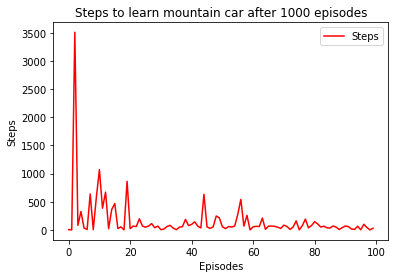

In [97]:
env = mountaincar.MountainCar()            
theta_sarsa, line = play_sarsa(env, theta=[])
plot_graph(line)

In [85]:
agents = 10 # Choose numbers of agents.
lines = []
for i in range(agents):
    env = mountaincar.MountainCar()            
    the, line = play_sarsa(env, theta=[])
    lines.append(line)

avg_line_sarsa = []
for j in range(0, len(line)):
    avg = 0
    for line in lines:
        avg += line[j]
    avg = avg / len(lines)
    avg_line_sarsa.append(avg)

it's working
it's working
it's working
it's working
it's working
it's working
it's working
it's working
it's working
it's working


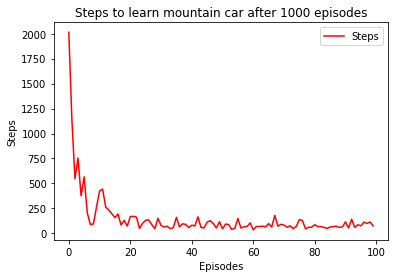

In [86]:
plot_graph(avg_line_sarsa)

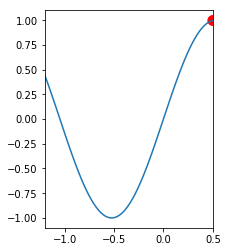

In [87]:
# Run this cell after cells above, to see mountain car run after 1000 episodes.
redundant_t, redundant_line = play_sarsa(env, theta_sarsa, episodes=1, plot=True)

Please make sure that all of your code is above this cell. Here, please insert your static learning curve and answer the verbal questions (describe your choice of parameters and results). 

YOUR ANSWER HERE
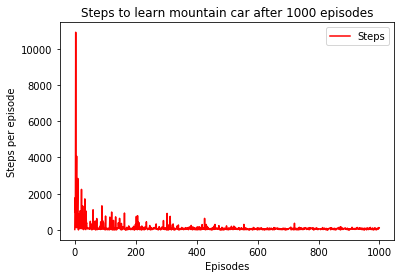


## Part 2 (50 marks)


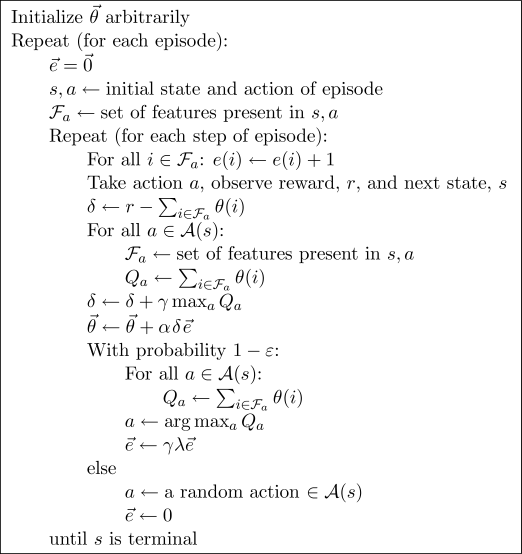

In [88]:
def play_watkins(env, theta, lambada=0.9, alpha=0.01, epsilon=0.05, gamma=1, episodes=100, plot=False):
    
    t = Tiling(env) # Creates tiling object.
    t.make_tiles() # Creates tiling.
    
    # Checks to see if game is running with a used theta or a new one is needed to be initialised.
    if not list(theta):
        theta = np.zeros(t.n) 
        
    # List is used to accumulate steps in each episode.
    step_list = []
    print("Its working")
    for episode in range(episodes):
        step = 0 # Initialises steps at the beginning of each episode
        env.reset()
        e = np.zeros(t.n) # Initialises eligibility trace.
        delta = 0 # Sets default value of 0 to delta.
        
        # Current state of game and chooses random action to start game.
        state = (env.position, env.velocity)
        action = random.choice(env.actions)
        
        # Loop for each step of the game.
        while not env.game_over:
            fa = t.get_tile_indices(state, action)
            for i in fa:
                e[i] += 1 # Accumulating traces.
            reward = env.make_step(action)
            state_prime = (env.position, env.velocity)
            delta = reward - get_Q(fa, theta)
            
            action_prime, Q_prime = policy(t, state_prime, fa, theta) # index_q is not used.
            
            # Updates
            delta = delta + gamma * Q_prime
            theta = theta + (e * delta * alpha)
            
            # Greedy policy 'Ɛ'.
            if np.random.uniform(0, 1) > epsilon: 
                action_prime, Q_prime = policy(t, state_prime, fa, theta)
                e = e * gamma * lambada
            else:
                action_prime = random.choice(env.actions)
                e = np.zeros(t.n)

            # Plots mountain car.
            if plot:
                env.plot()
            
            # Makes state prime the state for the next step of episode.
            state = state_prime
            action = action_prime
            
            # Accumulate steps.
            step = step + 1
        
        # Appends steps taken in episode to list.
        step_list.append(step)
    return theta, step_list

In [89]:
agents = 10
lines = []
for i in range(agents):
    env = mountaincar.MountainCar()            
    the, line1 = play_watkins(env, theta=[])
    lines.append(line1)

avg_line_watkins = []
for j in range(0, len(line)):
    avg = 0
    for line in lines:
        avg += line[j]
    avg = avg / len(lines)
    avg_line_watkins.append(avg)

Its working
Its working
Its working
Its working
Its working
Its working
Its working
Its working
Its working
Its working


Its working


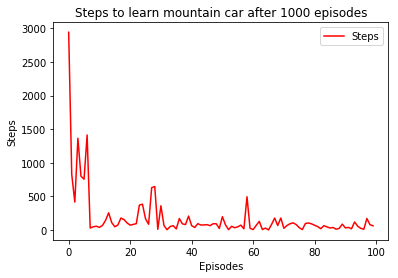

In [90]:
# Cell to run watkins for one series of episodes.
env = mountaincar.MountainCar()            
theta_watkins, line_watkins = play_watkins(env, theta=[])
plot_graph(line_watkins)

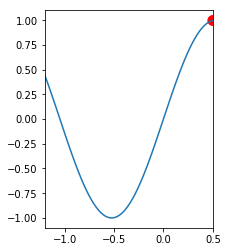

In [91]:
redundant_t, redundant_line = play_watkins(env, theta_watkins, episodes=1, plot=True)

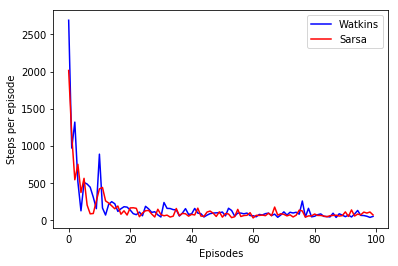

In [92]:
x = np.arange(0, len(line))
fig, (ax1) = plt.subplots(1,1)
ax1.plot(x, avg_line_watkins, color="blue", label="Watkins")
ax1.plot(x, avg_line_sarsa, color="red", label="Sarsa")
#ax1.set_title("Average of 10 Agents using Watkins and Sarsa")
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Steps per episode')
plt.legend()
plt.show()

Please make sure that all of your code is above this cell. Please insert a static learning curve, showing the performance of your learning over time, and answer the questions provided on the coursework specification. Instead of providing your answer here, in this Jupyter notebook, you have the option to provide your answers on a separate pdf document, not exceeding two pages in length. If you do so, please write "Answer in pdf file." in this cell.  

YOUR ANSWER HERE
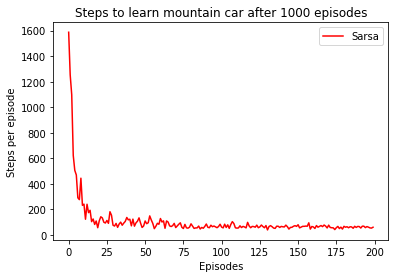

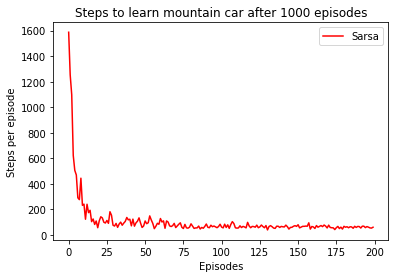

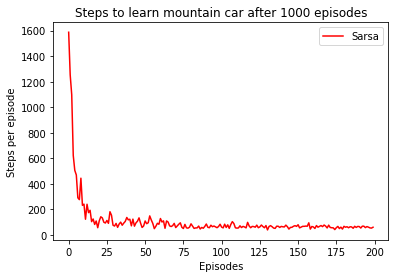
